Objectives: <br>
1. Find correlation between a 'Theoretical RDM' and 'Output RDM' from a Vision Transformer Model for each layer of the model, <br>
2. The Correlation Class supports both test types orientation selectivity and shape perception.

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os
import glob
import math
import statistics

## Main Class

In [16]:
class Correlation:
    def __init__(self,
                 csv_files: List[str],
                 theoretical_rdm_path: List[str],
                ):
        self.csv_files = csv_files
        self.theoretical_rdm_path = theoretical_rdm_path

        self.theoretical_rdm = self.process_csv(files=self.theoretical_rdm_path)

        # load and process all csv files
        self.scores = self.process_csv(files=self.csv_files)

        # get correlation for each layer
        self.output = self.p_corr(rel=self.scores)

    def process_csv(self, files):
        # store output against layer name
        scores = {}
        
        for f in files:
            # get layer name to store in dict
            layer = f.split("/")[-1].split(".")[0]
            
            # load csv file containing RDM scores
            sc = pd.read_csv(f, header=None)

            # convert to float if RDM has int values
            is_integer = np.issubdtype(sc.values.dtype, np.integer)
            if is_integer == True:
                print("[INFO] Found RDM value of int type. Converting to float...")
                sc = sc.astype(float)
            
            # set diagonal elements to NaN
            np.fill_diagonal(sc.values, np.nan)

            # transpose grid into a single column
            sc = sc.stack() # drops NaN by default
            
            # store in dictionary
            scores[layer] = sc

        return scores     

    def p_corr(self, rel):
        # store corr for each layer here
        output = {}

        for key in rel.keys():
            correlation = rel[key].corr(self.theoretical_rdm['theoretical_rdm'])
            output[key] = correlation.round(5)
            
        return output


def plot_lineGraph(output_untrained, output_trained, legend=False):

    if len(output_trained) != len(output_untrained):
        raise ValueError("Data mismatch. Check output!")

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=[7,5])

    
    layer_count = len(output_untrained)
    # establish x-axis labels
    x = []
    for i in range(1,layer_count+1): # start layer name from 1
        x.append('Layer {}'.format(i))

    # add y-axis data points
    trained = []
    untrained = []

    for un_val, tr_val in zip(output_untrained.values(), output_trained.values()):
        untrained.append(un_val)
        trained.append(tr_val)

    # plot lines
    ax.errorbar(x, trained, fmt='-o', label='Trained', color='darkgreen')
    ax.errorbar(x, untrained, fmt='-o', label='Untrained', color='red')
    
    # Set y-axis limits
    ax.set_ylim([-0.3, 1.0])
    
    # Set the y-axis tick locations to be evenly spaced between 0 and 1
    y_tick_locs = np.linspace(0.1, 1.0, 10)
    ax.set_yticks(y_tick_locs)
    
    # Adjust tick font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    if legend == True:
        ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.5, 1))
    
    # Plot graph
    plt.show()

### Code for three seeds

In [17]:
def get_correlation(csv_files, theoretical_rdm_path):
    oc = Correlation(csv_files=csv_files, theoretical_rdm_path=theoretical_rdm_path)
    return oc.output

def evaluate(model_root_path, training_size, theoretical_rdm_path):
    # to store final output for each seed
    output = {}
    output['seed0'] = [] # store seed0 corr with theoretical RDM
    output['seed1'] = [] # store seed1 corr with theoretical RDM
    output['seed2'] = [] # store seed2 corr with theoretical RDM

    for i in range(3):
        seed = str("seed{}".format(i))
        csv_path = os.path.join(model_root_path, training_size, seed)
        # Get full paths of all CSV files
        csv_files = glob.glob(f"{csv_path}/*.csv")
        csv_files = sorted(csv_files)
    
        #print("[INFO seed{}]".format(i), csv_files)
    
        # Compute correlation for each seed
        corr_trained = get_correlation(csv_files, theoretical_rdm_path)
        print("[CORR SEED {}]".format(i), corr_trained, "\n")
    
        output['seed{}'.format(i)].append(corr_trained)
    
    #print(output,"\n")
    
    # extract corr scores for each seed
    seed0 = output['seed0'][0]
    seed1 = output['seed1'][0]
    seed2 = output['seed2'][0]
    
    
    avg = []
    std_err = []
    for (k0,v0), (k1,v1), (k2,v2) in zip(seed0.items(), seed1.items(), seed2.items()):
        assert k0==k1==k2
    
        values = [v0, v1, v2]
    
        # calculate avg score
        mean = round(statistics.mean(values), 4)
        avg.append(mean)
    
        # calculate standard error
        se = statistics.stdev(values) / math.sqrt(len(values))
        std_err.append(round(se, 4))
    
    print("[AVG]    ", avg)
    print("[STD ERR]", std_err, "\n")
    return avg, std_err

def line_graph(avg_trained, std_err_trained, avg_untrained, std_err_untrained, avg_tt2, std_err_tt2): # , , , avg_bs, std_err_bs, avg_lt, std_err_lt, avg_ws, std_err_ws

    num_layers = len(avg_trained[0])
    x = []
    for i in range(1,num_layers+1):
        layer_name = 'Layer {}'.format(i)
        x.append(layer_name)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=[7,5]) 

    # trained model
    for i, (score, err) in enumerate(zip(avg_trained, std_err_trained)):
        ax.plot(x, score, '-o', label='', color="darkgreen")
        ax.fill_between(x, np.array(score) - np.array(err), 
                           np.array(score) + np.array(err), 
                           color="darkgreen", alpha=0.2)

    # untrained model
    for i, (score, err) in enumerate(zip(avg_untrained, std_err_untrained)):
        ax.plot(x, score, '-o', label='', color="red")
        ax.fill_between(x, np.array(score) - np.array(err), 
                           np.array(score) + np.array(err), 
                           color="red", alpha=0.2)

    # tt2 model
    for i, (score, err) in enumerate(zip(avg_tt2, std_err_tt2)):
        ax.plot(x, score, '-o', label='', color="darkblue")
        ax.fill_between(x, np.array(score) - np.array(err), 
                           np.array(score) + np.array(err), 
                           color="darkblue", alpha=0.2)

    # # window size 1 model
    # for i, (score, err) in enumerate(zip(avg_ws, std_err_ws)):
    #     ax.plot(x, score, '-o', label='', color="orange")
    #     ax.fill_between(x, np.array(score) - np.array(err), 
    #                        np.array(score) + np.array(err), 
    #                        color="orange", alpha=0.2)

    # # batch size model
    # for i, (score, err) in enumerate(zip(avg_bs, std_err_bs)):
    #     ax.plot(x, score, '-o', label='', color="purple")
    #     ax.fill_between(x, np.array(score) - np.array(err), 
    #                        np.array(score) + np.array(err), 
    #                        color="purple", alpha=0.2)

    # # batch size model
    # for i, (score, err) in enumerate(zip(avg_lt, std_err_lt)):
    #     ax.plot(x, score, '-o', label='', color="black")
    #     ax.fill_between(x, np.array(score) - np.array(err), 
    #                        np.array(score) + np.array(err), 
    #                        color="black", alpha=0.2)
    
      
    # Set y-axis limits
    ax.set_ylim([-0.3, 1.0])
    
    # Set the y-axis tick locations to be evenly spaced between 0 and 1
    y_tick_locs = np.linspace(0.1, 1.0, 10)
    ax.set_yticks(y_tick_locs)
    
    # Adjust tick font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    # Plot graph
    plt.show()

[INFO] Found RDM value of int type. Converting to float...
[CORR SEED 0] {'layer_0': 0.0953, 'layer_1': 0.24519, 'layer_2': 0.53157, 'layer_3': 0.54112, 'layer_4': 0.02687, 'layer_mlp_head': 0.82754} 

[INFO] Found RDM value of int type. Converting to float...
[CORR SEED 1] {'layer_0': 0.15761, 'layer_1': 0.42692, 'layer_2': 0.47836, 'layer_3': 0.63408, 'layer_4': 0.61386, 'layer_mlp_head': 0.80192} 

[INFO] Found RDM value of int type. Converting to float...
[CORR SEED 2] {'layer_0': 0.0953, 'layer_1': 0.24519, 'layer_2': 0.53157, 'layer_3': 0.54112, 'layer_4': 0.02687, 'layer_mlp_head': 0.82754} 

[AVG]     [0.1161, 0.3058, 0.5138, 0.5721, 0.2225, 0.819]
[STD ERR] [0.0208, 0.0606, 0.0177, 0.031, 0.1957, 0.0085] 

[INFO] Found RDM value of int type. Converting to float...
[CORR SEED 0] {'layer_0': -0.13181, 'layer_1': -0.13186, 'layer_2': -0.13914, 'layer_3': -0.13561, 'layer_4': -0.13249, 'layer_mlp_head': -0.12651} 

[INFO] Found RDM value of int type. Converting to float...
[CORR S

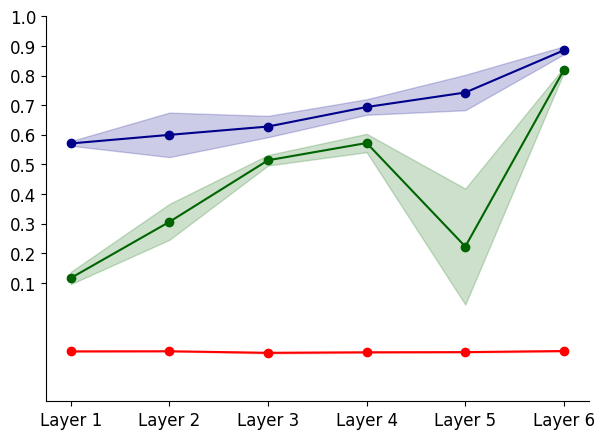

In [14]:
### MAIN CALL ###

theoretical_rdm_path = ["/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/Shape_RDMs/theoretical_rdm.csv"]

plot_AVG_trained, plot_SE_trained = [],[]
plot_AVG_untrained, plot_SE_untrained = [],[]
plot_AVG_scrm, plot_SE_scrm = [],[]
plot_AVG_windowsize, plot_SE_windowsize = [],[]
plot_AVG_batch, plot_SE_batch = [],[]
plot_AVG_lt, plot_SE_lt = [],[]
plot_AVG_tt2, plot_SE_tt2 = [],[]


# You can plot multiple lines with the below list
#dataset_size_tr = ["10k","20k","40k","80k","160k"]

# plot line for TRAINED MODEL
model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/Shape_RDMs/vit6h/160k/non_scrambled_models/"
dataset_size_tr = ["visual_binding_testset"]


for training_size in dataset_size_tr:
    av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
    plot_AVG_trained.append(av)
    plot_SE_trained.append(std)


# # plot line for UNTRAINED MODEL
model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/Shape_RDMs/vit6h/"
dataset_size_unt = ["untrained"]

for training_size in dataset_size_unt:
    av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
    plot_AVG_untrained.append(av)
    plot_SE_untrained.append(std)

# plot line for test type 2
model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/Shape_RDMs/vit6h/160k/non_scrambled_models/"
dataset_size_scram = ["complex_shape_testset"]

for training_size in dataset_size_scram:
    av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
    plot_AVG_tt2.append(av)
    plot_SE_tt2.append(std)


# # plot line for window_size 1 MODEL
# model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/Shape_RDMs/vit6h/160k/scrambledModels/fullTemporalShuffle/"
# dataset_size_window = ["rebuttal"]

# for training_size in dataset_size_window:
#     av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
#     plot_AVG_windowsize.append(av)
#     plot_SE_windowsize.append(std)

# # plot line for window_size 1 MODEL
# model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_kittenAI/cognition_revision_experiments/chick_retinalWave/OrientationSelectivity_RDMs/vit3h/controlled_experiments/"
# dataset_size_batch = ["64batchsize"]

# for training_size in dataset_size_batch:
#     av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
#     plot_AVG_batch.append(av)
#     plot_SE_batch.append(std)


# # plot line for window_size 1 MODEL
# model_root_path = "/data/lpandey/LOGS/CSV_FILES/paper_kittenAI/cognition_revision_experiments/chick_retinalWave/OrientationSelectivity_RDMs/vit3h/controlled_experiments/"
# dataset_size_batch = ["128x128_16x16_res"]

# for training_size in dataset_size_batch:
#     av, std = evaluate(model_root_path, training_size, theoretical_rdm_path)
#     plot_AVG_lt.append(av)
#     plot_SE_lt.append(std)



### PLOT GRAPH ###
#plot_AVG_scrm = [[0.2735, 0.250, 0.339, 0.3593, 0.439, 0.8798]]
#plot_SE_scrm = [[0.0169, 0.0489, 0.0384, 0.0239, 0.0478, 0.0066]]
# remove the scrambling arguments to make a two line graph!
line_graph(
    plot_AVG_trained, plot_SE_trained, 
    plot_AVG_untrained, plot_SE_untrained, 
    plot_AVG_tt2, plot_SE_tt2, 
    # plot_AVG_windowsize, plot_SE_windowsize,
    # plot_AVG_batch, plot_SE_batch,
    # plot_AVG_lt, plot_SE_lt
)

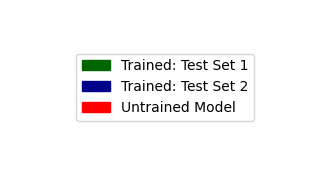

In [19]:
# generate legend
import matplotlib.patches as mpatches

# Define custom legend handles
trained_patch = mpatches.Patch(color='darkgreen', label='Trained: Test Set 1')
scrambled_patch = mpatches.Patch(color='darkblue', label='Trained: Test Set 2')
untrained_patch = mpatches.Patch(color='red', label='Untrained Model')

# ws1_patch = mpatches.Patch(color='orange', label='Training epochs: 50')
# bs = mpatches.Patch(color='purple', label='Batch size: 64')
# new = mpatches.Patch(color='black', label='Image res: 128x128 (less training)')


# Create legend
plt.figure(figsize=(4, 2))
plt.legend(handles=[trained_patch, scrambled_patch, untrained_patch ], loc='center')
plt.axis('off')  # hide axes
plt.show()

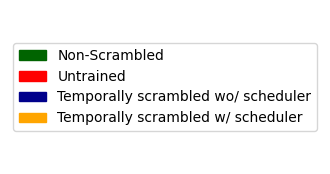

In [18]:
# generate legend
import matplotlib.patches as mpatches

# Define custom legend handles
trained_patch = mpatches.Patch(color='darkgreen', label='Non-Scrambled')
untrained_patch = mpatches.Patch(color='red', label='Untrained')
scrambled_patch = mpatches.Patch(color='darkblue', label='Temporally scrambled wo/ scheduler')
ws1_patch = mpatches.Patch(color='orange', label='Temporally scrambled w/ scheduler')



# Create legend
plt.figure(figsize=(4, 2))
plt.legend(handles=[trained_patch, untrained_patch, scrambled_patch, ws1_patch], loc='center')
plt.axis('off')  # hide axes
plt.show()

### Code for a single seed with no standard error plotting

[INFO] Untrained Layer-Wise Correlation -  {'untrained_layer_0': 0.19298, 'untrained_layer_1': 0.1807, 'untrained_layer_2': 0.19233, 'untrained_layer_3': 0.19561, 'untrained_layer_4': 0.17305, 'untrained_mlp_head': 0.14555}
[INFO] Trained Layer-Wise Correlation -  {'layer_0': 0.2976, 'layer_1': 0.22631, 'layer_2': 0.28664, 'layer_3': 0.19287, 'layer_4': 0.21055, 'layer_mlp_head': -0.09009}


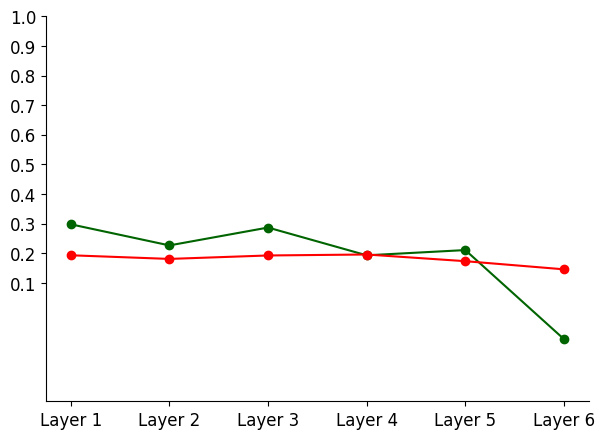

In [61]:
# Pass CSV paths for trained and untrained layers
csv_files_TRAINED = [
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_0.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_1.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_2.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_3.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_4.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/10k/seed2/layer_mlp_head.csv',
]

csv_files_UNTRAINED = [
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_layer_0.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_layer_1.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_layer_2.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_layer_3.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_layer_4.csv',
'/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/untrained_mlp_head.csv',
]

# Pass CSV path for the theoretical RDM
theoretical_rdm_path = ["/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/theoretical_rdm.csv"]

# Main Function
def get_correlation(csv_files, theoretical_rdm_path):
    oc = Correlation(csv_files=csv_files, theoretical_rdm_path=theoretical_rdm_path)
    return oc.output

# TODO: put the below code inside a loop and run it three times. store the output in a dictionary for individual seeds.
# TODO: Make a new data structure such that you average across three seeds and calculate the std_deviation and store it in that data structure.

# Compute outputs
output_untrained = get_correlation(csv_files_UNTRAINED, theoretical_rdm_path)
output_trained = get_correlation(csv_files_TRAINED, theoretical_rdm_path)

# Display outputs
print("[INFO] Untrained Layer-Wise Correlation - ", output_untrained)
print("[INFO] Trained Layer-Wise Correlation - ", output_trained)

# Plot line graph
plot_lineGraph(output_untrained=output_untrained, output_trained=output_trained, legend=False)